# Game Flow Incorporating Momentum
Takes in the game flow array of probabilities and modifies them according to various explanatory variables.

In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import itertools # for shortening double-loop code.
%matplotlib inline
plt.style.use('ggplot')

In [209]:
# Functions

# Probability Functions

# Find the probability of winning a game given probability winning a point
def prob_hold(p):
    """Probability server holds."""
    q = 1-p
    return (
        p**4 +
        4*(p**4)*q + 
        10*(p**4)*(q**2) + 
        (20*(p**3)*(q**3)) * ((p**2)/(1 - 2*p*q))
    )

# Find the probability of winning a set given probability winning a game
def prob_win_set(ps):
    """Probability server holds."""
    qs = 1-ps
    return (
        ps**6 +
        6*(ps**6)*qs + 
        21*(ps**6)*(qs**2) + 
        56*(ps**6)*(qs**3) +
        126*(ps**6)*(qs**4) +
        42*(ps**7)*(qs**5) +
        924*(ps**7)*(qs**6)
    )

# Find the probability of winning a match given probability winning a set
def prob_win_match(pm):
    """Probability server holds."""
    qm = 1-pm
    return (
        pm**3 +
        3*(pm**3)*qm + 
        6*(pm**3)*(qm**2)
    )

def get_serve_probability(match_data, player):
    serve_no = match_data['server'].values
    point_victor = match_data['point_victor'].values

    serve_point_won = 0
    num_serves = 0

    p_array = []

    for index in range(len(serve_no)):
        if player == serve_no[index]:
            num_serves += 1

            if player == point_victor[index]:
                serve_point_won += 1

        if num_serves == 0:
            p_array.append(0)
        else:
            p_array.append(serve_point_won / num_serves)

    return p_array

def prob_win_independent_game(p1, p2):
    p1_holds_game = prob_hold(p1)
    p1_concedes_game = (1 - p1_holds_game)

    p2_holds_game = prob_hold(p2)
    p2_concedes_game = (1 - p2_holds_game)

    ps1 = (p1_holds_game + p2_concedes_game) / 2 # Prob p1 wins any independent game
    ps2 = (p2_holds_game + p1_concedes_game) / 2 # Prob p2 wins any independent game

    return ps1, ps2

# Momentum Modifier Functions

# change probability if player wins set
def modify_momentum(match_data, probability_array, player, r=1.3, q=0.4):
    '''
    When a player wins a set their "points" will increase by an exponential amount. When they lose a set their "points" will decrease but this change isn't as significant.
    '''
    # n = number of sets won
    n = 0
    lost = 0
    loss_factor = 1
    #x = 1.25

    for index in range(len(probability_array)):
        set_victor_array = match_data['set_victor'].values
        won_set = set_victor_array[index] == player

        if (won_set):
            n += 1
            n = n
        elif set_victor_array[index] == 3 - player:
            lost += 1
            # probability_array[index] = probability_array[index]/(2*lost)
            loss_factor = 1 + (q * lost)

        probability_array[index] = (((r**n)-1)/(r**n) + (1/(r**n))*probability_array[index]) ** loss_factor
        

    return probability_array

def modify_momentum_err(match_data, momentum_array, player, s=0.0035):
    '''
    Calculates the total number of unforced errors for a player and their opponent. For each additional unforced error a player commits, they will lose 0.0035 "points.
    For each additional unfrced error their opponent commits, they will gain 0.0035 "points".
    '''

    # unforced error total
    n = 0
    m = 0

    unf_err_array = match_data[f'p{player}_unf_err'].values
    for index in range(len(momentum_array)):
        unf_err = unf_err_array[index] == 1

        if (unf_err):
            n += 1

    unf_err_array_2 = match_data[f'p{3-player}_unf_err'].values
    for index in range(len(momentum_array)):
        unf_err_2 = unf_err_array_2[index] == 1

        if (unf_err_2):
            m += 1

        if n>= 0:
            momentum_array[index] = momentum_array[index]-s*n + s*m
            if momentum_array[index] < 0:
                momentum_array[index] = 0
    return momentum_array

def points_scored(match_data, points_array, player, uu= 1.005, cc=0.0001):
    '''
    When a player wins a set their "points" will increase by an exponential amount. When they lose a set their "points" will decrease but this change isn't as significant.
    '''
    # w = number of points won
    ww = 0
    mm = 0
    lost_factor=1

    for index in range(len(points_array)):
        points_victor_array = match_data['point_victor'].values
        won_point = points_victor_array[index] == player

        if (won_point):
            ww += 1
    
    for index in range(len(points_array)):
        points_loss_array = match_data['point_victor'].values
        lost_point = points_loss_array[index] == 3 - player

        if (lost_point):
            mm += 1
            lost_factor = 1 + (mm * cc)

        points_array[index] = (((uu**ww)-1)/(uu**ww) + (1/(uu**ww)))*points_array[index]-mm*cc
        

    return points_array

In [210]:
# 1 - Calculate serve probability (points_on_serves / total serves)
# 2 - Calculate probability of winning a game from serve probability for each player
# 3 - Calculate probability of winning a set from the player win game probability
# 4 - Calculate probability of winning a match from the player win set probability
# 5 - Graph the probability of winning the set as point values increase

class MarkovChain:
    def __init__(self, file, match_to_examine):
        raw_data = pd.read_csv(file)
        self.match = raw_data[raw_data['match_id'] == match_to_examine]
        self.player1_name = self.match['player1'].values[0]
        self.player2_name = self.match['player2'].values[0]
        self.max_length = 0
        self.p1_momentum = []
        self.p2_momentum = []

    # 1 - Get serve probabilities
    def get_serve_probabilities(self, debug=False):
        p1_probability = get_serve_probability(self.match, 1)
        p2_probability = get_serve_probability(self.match, 2)
    
        if debug:
            print("Probability of winning a serve")
            print(p1_probability)
            print(p2_probability)
    
        # Get the maximum length between both probability arrays
        self.max_length = max(len(p1_probability), len(p2_probability))

        return p1_probability, p2_probability
    

    #  2 - Get probability of winning the game
    def get_game_probabilities(self, p1_probability, p2_probability, debug=False):
        pg1_array = []
        pg2_array = []

        for index in range(self.max_length):
            pg1, pg2 = prob_win_independent_game(p1_probability[index], p2_probability[index])

            pg1_array.append(pg1)
            pg2_array.append(pg2)

        if debug:
            print("Probability of winning the game")
            print(pg1_array)
            print(pg2_array)

        return pg1_array, pg2_array
    
    # 3 - Get probability of winning the set.
    def get_set_probabilities(self, pg1_array, pg2_array, debug=False):
        ps1_array = []
        ps2_array = []

        for index in range(self.max_length):
            ps1_array.append(prob_win_set(pg1_array[index]))
            ps2_array.append(prob_win_set(pg2_array[index]))

        if debug:
            print("Probability of winning the set")
            print(ps1_array)
            print(ps2_array)

        return ps1_array, ps2_array
    
    # 4 - Get probability of winning the match
    def get_match_probabilities(self, ps1_array, ps2_array, debug=False):
        pm1_array = []
        pm2_array = []

        for index in range(self.max_length):
            pm1_array.append(prob_win_match(ps1_array[index]))
            pm2_array.append(prob_win_match(ps2_array[index]))

        if debug:
            print("Probability of winning the match")
            print(pm1_array)
            print(pm2_array)

        return pm1_array, pm2_array

## Calls all functions that incorporate momentum    
    def update_momentum(self, pm1_array, pm2_array, debug=False):
        p1_momentum = modify_momentum(self.match,  pm1_array, 1)
        p2_momentum = modify_momentum(self.match, pm2_array, 2)

        p1_momentum1 = modify_momentum_err(self.match, p1_momentum, 1)
        p2_momentum2 = modify_momentum_err(self.match, p2_momentum, 2)

        p1_momentum11 = points_scored(self.match, p1_momentum1, 1)
        p2_momentum22 = points_scored(self.match, p2_momentum2, 2)

        if debug:
            print(p1_momentum1)
            print(p2_momentum2)

        return p1_momentum11, p2_momentum22
    
    # 5 - Graph
    def graph_momentum(self):
        # graph the performance of match flow + momentum
        set_change_points = []

        old_entry = 1
        for index, entry in enumerate(self.match['set_no']):
            if entry != old_entry:
                set_change_points.append(index + 1)
                old_entry = entry

        plt.title("Game Flow")
        plt.plot(range(len(self.p1_momentum)), self.p1_momentum, color="red", label=f"{self.player1_name}")
        plt.plot(range(len(self.p2_momentum)), self.p2_momentum, color="blue", label=f"{self.player2_name}")
        plt.xlabel("Point Number")
        plt.ylabel("Performance Rate")
        plt.legend()

        plt.text(20, -.04, 'Set 1', verticalalignment='bottom')
        for index, value in enumerate(set_change_points):
            plt.axvline(x=value, color='gray', linestyle='--')
            plt.text(value + 20, -.04, f"Set {index + 2}", verticalalignment='bottom')

        plt.show()

    def prediction(self, verbose=True):
        # Find who was performing better before sets 3 4 and 5
        set_change_points = []


        old_entry = 1
        for index, entry in enumerate(self.match['set_no']):
            if entry != old_entry:
                set_change_points.append(index + 1)
                old_entry = entry
        for index, value in enumerate(set_change_points):
            if index == 1:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_3_pred = self.player1_name
                    if verbose:
                        print(self.player1_name, "is winning going into set 3 with: ", self.p1_momentum[value], "momentum")
                else:
                    set_3_pred = self.player2_name
                    if verbose:
                        print(self.player2_name, "is winning going into set 3 with: ", self.p2_momentum[value], "momentum")

            elif index == 2:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_4_pred = self.player1_name
                    if verbose:
                        print(self.player1_name, "is winning going into set 4 with: ", self.p1_momentum[value], "momentum")
                else:
                    set_4_pred = self.player2_name
                    if verbose:
                        print(self.player2_name, "is winning going into set 4 with: ", self.p2_momentum[value], "momentum")

            elif index == 3:
                if self.p1_momentum[value] > self.p2_momentum[value]:
                    set_5_pred = self.player1_name
                    if verbose:
                        print(self.player1_name, "is winning going into set 5 with: ", self.p1_momentum[value], "momentum")
                elif self.p1_momentum[value] < self.p2_momentum[value]:
                    set_5_pred = self.player2_name
                    if verbose:
                        print(self.player2_name, "is winning going into set 5 with: ", self.p2_momentum[value], "momentum")
                else: 
                    set_5_pred = 0

        set_victors = self.match['set_victor']
        final_point = set_victors.iloc[-1]
        if final_point == 1:
            winner = self.player1_name
        else:
            winner = self.player2_name
        #print(winner, "won the game")

        verbose = True
        if verbose:
            for index, value in enumerate(set_change_points):
                if index == 1:
                    if winner == set_3_pred:
                        print("set 3 prediction is correct")
                    else:
                        print("set 3 prediction is wrong")
    
                elif index == 2:
                    if winner == set_4_pred:
                        print("set 4 prediction is correct")
                    else:
                        print("set 4 prediction is wrong")
                        
                elif index == 3:
                    if winner == set_5_pred:
                        print("set 5 prediction is correct")
                    else:
                        print("set 5 prediction is wrong")
            #

        self.set_change_points = set_change_points
        
        data = np.vstack([self.p1_momentum[self.set_change_points], self.p2_momentum[self.set_change_points]])
        data = data.T
        
        result_array = self.determine_results(data, final_point)

        return result_array
        # return data, final_point
        
    #
    
    def train(self, debug=False):        
        self.p1_momentum, self.p2_momentum = self.update_momentum(
            *self.get_match_probabilities( # 4
                *self.get_set_probabilities( # 3
                    *self.get_game_probabilities( # 2
                        *self.get_serve_probabilities(debug), debug), debug), debug), debug) # 1
        self.p1_momentum = np.array(self.p1_momentum)
        self.p2_momentum = np.array(self.p2_momentum)
        return
    
    def determine_results(self, data, win):
        predicted_winner = 1+(np.diff(data, axis=1) )        

        actual_winner = win*np.ones( np.shape(predicted_winner) )

        winner_number = actual_winner-1
        winner_number

        equal_elements = [i + 2 for i in range(len(predicted_winner)) if math.floor(predicted_winner[i]) == winner_number[i]]


        match_total_sets = len(predicted_winner)+1
        match_length = [i for i in range(2, match_total_sets+1)]
        result_array = np.vstack([1 if elem in equal_elements else 0 for elem in match_length])
        result_array

        return result_array

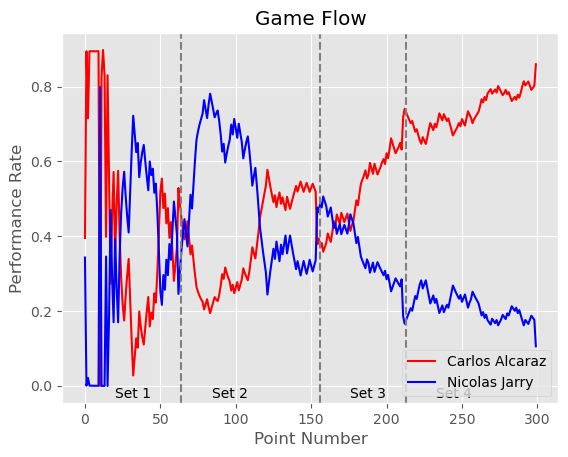

Nicolas Jarry is winning going into set 3 with:  0.4895592843337317 momentum
Carlos Alcaraz is winning going into set 4 with:  0.7305790438235578 momentum
set 3 prediction is wrong
set 4 prediction is correct


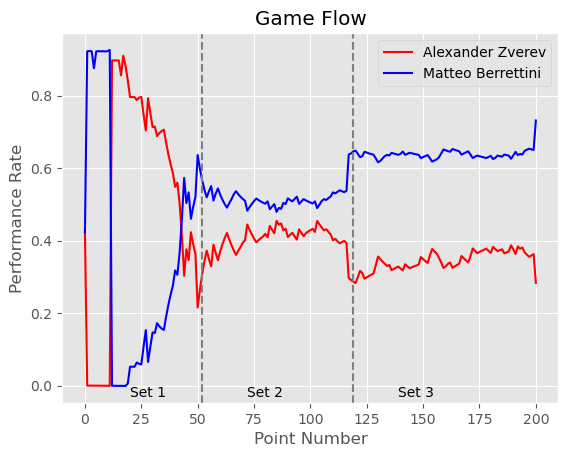

Matteo Berrettini is winning going into set 3 with:  0.646087769766289 momentum
set 3 prediction is correct


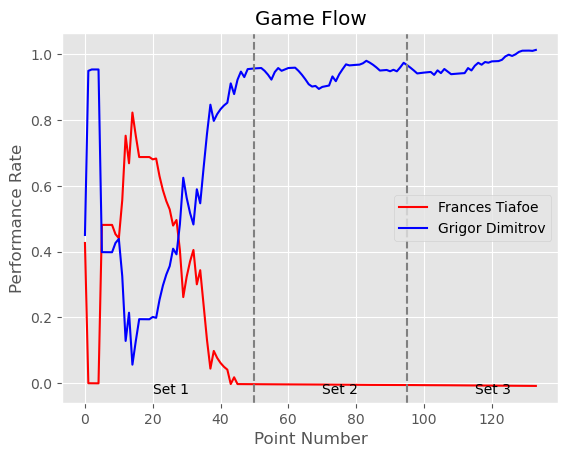

Grigor Dimitrov is winning going into set 3 with:  0.9676934890534843 momentum
set 3 prediction is correct


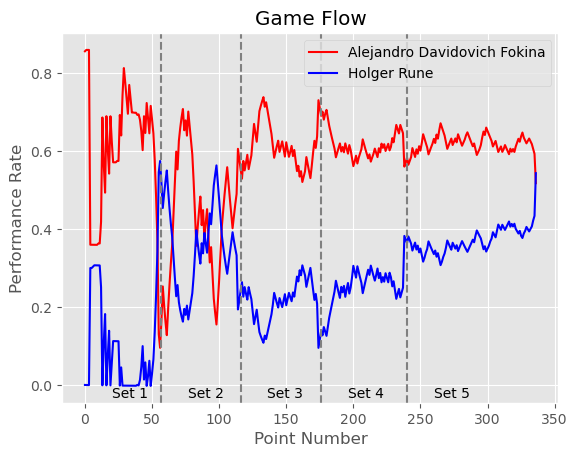

Alejandro Davidovich Fokina is winning going into set 3 with:  0.5538237906429073 momentum
Alejandro Davidovich Fokina is winning going into set 4 with:  0.6907987875148004 momentum
Alejandro Davidovich Fokina is winning going into set 5 with:  0.5836583388757087 momentum
set 3 prediction is wrong
set 4 prediction is wrong
set 5 prediction is wrong


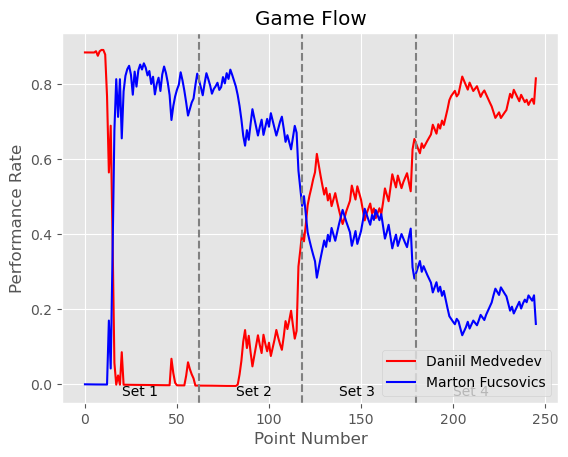

Marton Fucsovics is winning going into set 3 with:  0.4756237932911389 momentum
Daniil Medvedev is winning going into set 4 with:  0.6405446416984545 momentum
set 3 prediction is wrong
set 4 prediction is correct


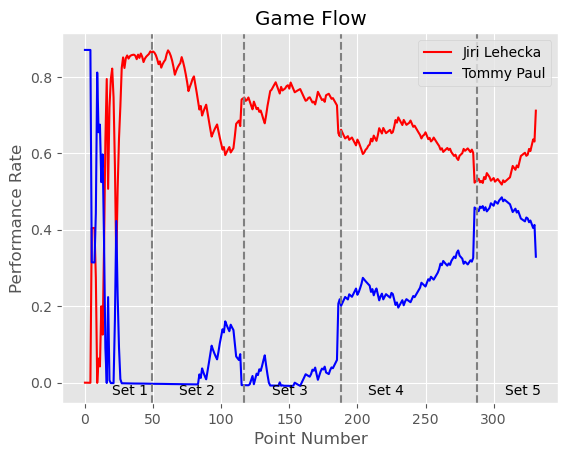

Jiri Lehecka is winning going into set 3 with:  0.7460280126188467 momentum
Jiri Lehecka is winning going into set 4 with:  0.6618206757940841 momentum
Jiri Lehecka is winning going into set 5 with:  0.5301673295592131 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


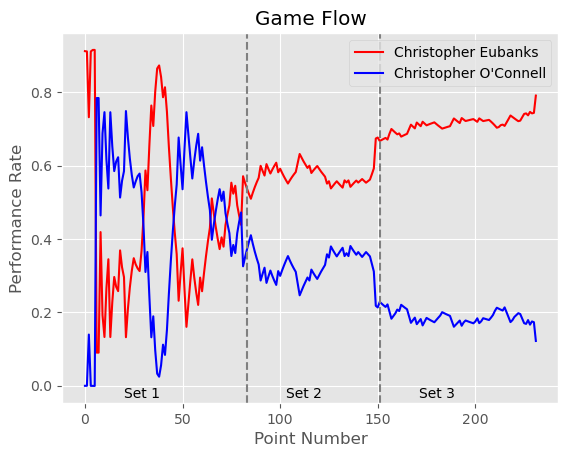

Christopher Eubanks is winning going into set 3 with:  0.6673935221203203 momentum
set 3 prediction is correct


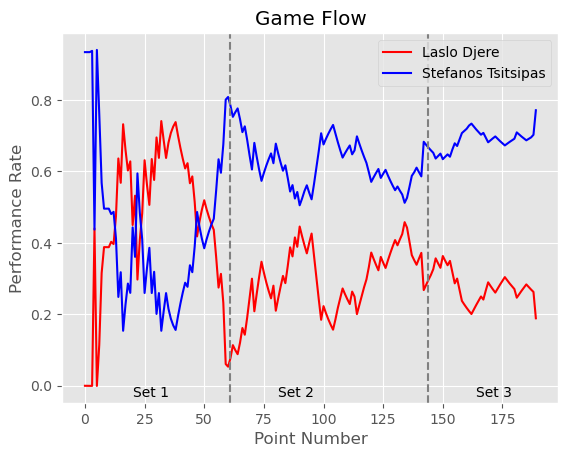

Stefanos Tsitsipas is winning going into set 3 with:  0.6662079070481551 momentum
set 3 prediction is correct


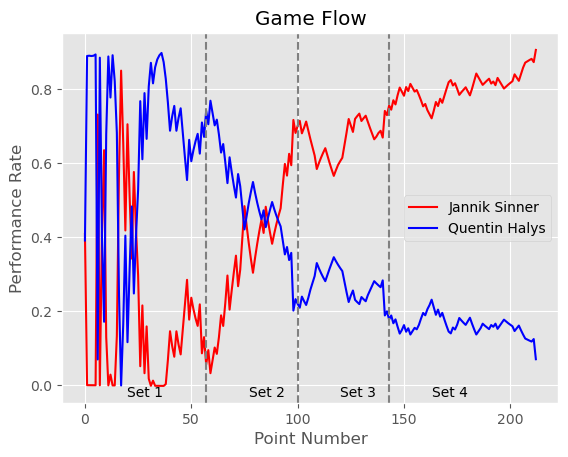

Jannik Sinner is winning going into set 3 with:  0.7013917599569414 momentum
Jannik Sinner is winning going into set 4 with:  0.7567242710148968 momentum
set 3 prediction is correct
set 4 prediction is correct


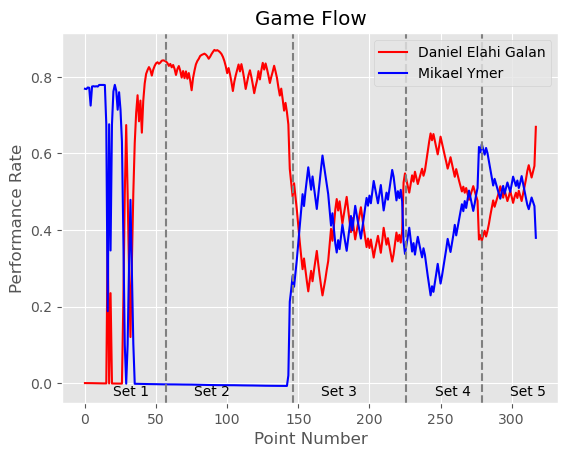

Daniel Elahi Galan is winning going into set 3 with:  0.48731747563483385 momentum
Daniel Elahi Galan is winning going into set 4 with:  0.5304066195889383 momentum
Mikael Ymer is winning going into set 5 with:  0.624272532501508 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is wrong


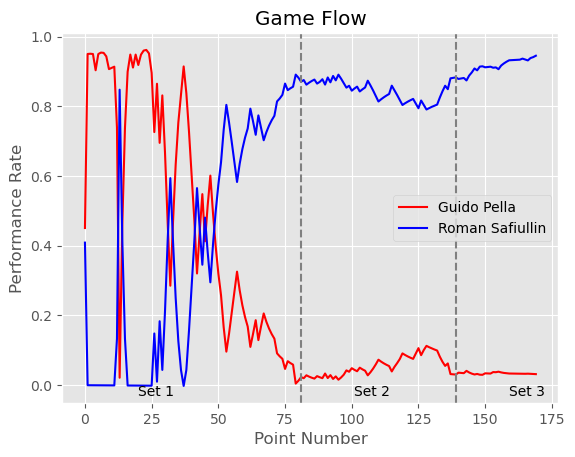

Roman Safiullin is winning going into set 3 with:  0.8830472648587566 momentum
set 3 prediction is correct


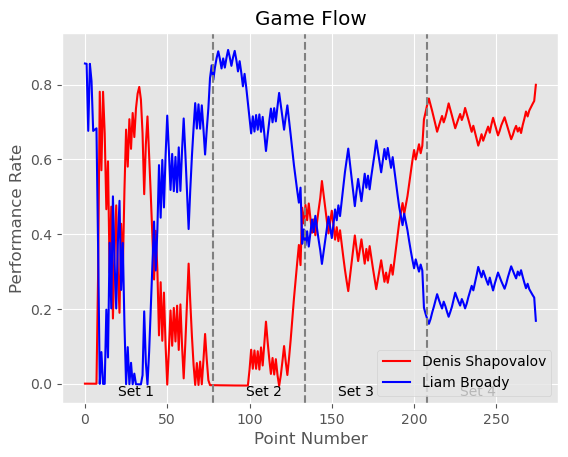

Denis Shapovalov is winning going into set 3 with:  0.47815221650047957 momentum
Denis Shapovalov is winning going into set 4 with:  0.7469795495402798 momentum
set 3 prediction is correct
set 4 prediction is correct


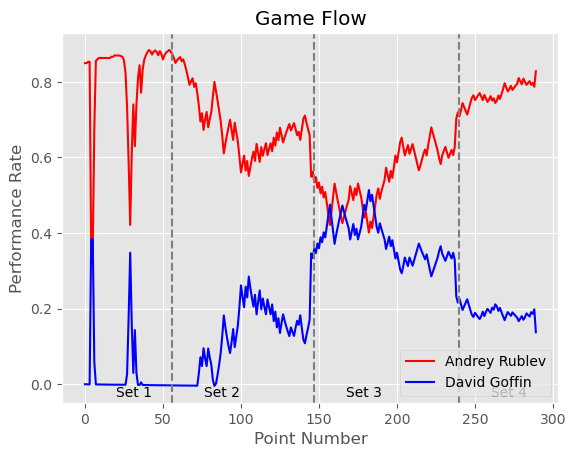

Andrey Rublev is winning going into set 3 with:  0.5342065716952548 momentum
Andrey Rublev is winning going into set 4 with:  0.7087499708709436 momentum
set 3 prediction is correct
set 4 prediction is correct


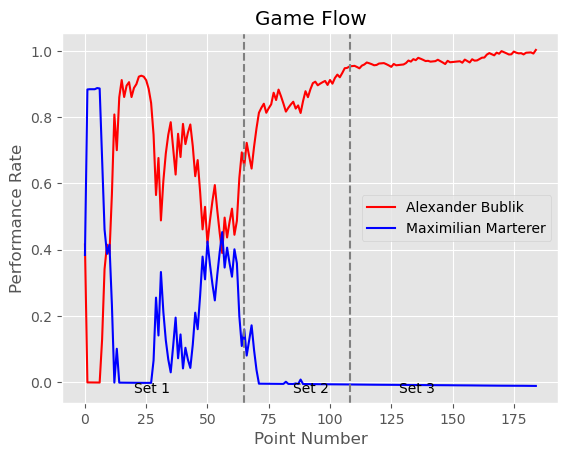

Alexander Bublik is winning going into set 3 with:  0.9532949180730086 momentum
set 3 prediction is correct


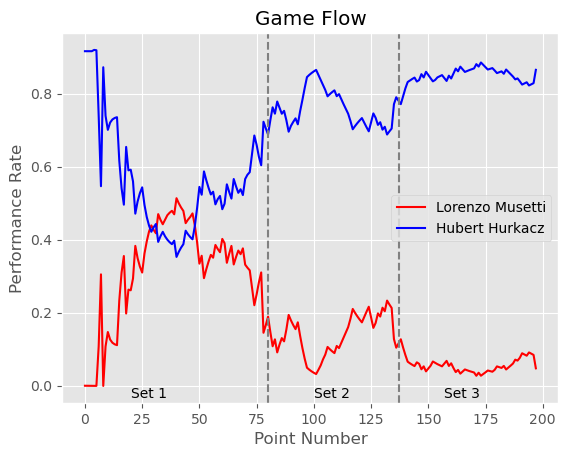

Hubert Hurkacz is winning going into set 3 with:  0.7803211572321391 momentum
set 3 prediction is correct


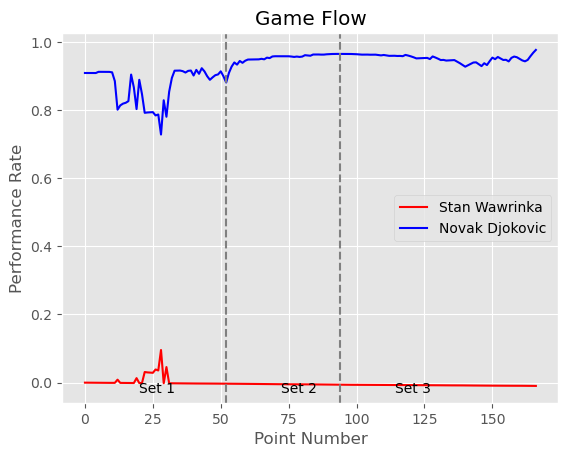

Novak Djokovic is winning going into set 3 with:  0.9650129977968677 momentum
set 3 prediction is correct


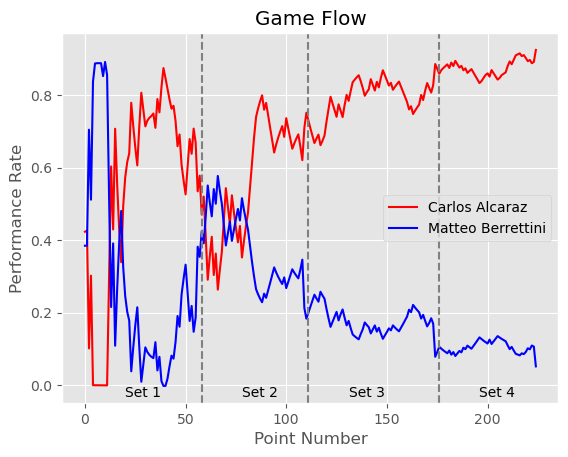

Carlos Alcaraz is winning going into set 3 with:  0.7293938223284382 momentum
Carlos Alcaraz is winning going into set 4 with:  0.8585381076561949 momentum
set 3 prediction is correct
set 4 prediction is correct


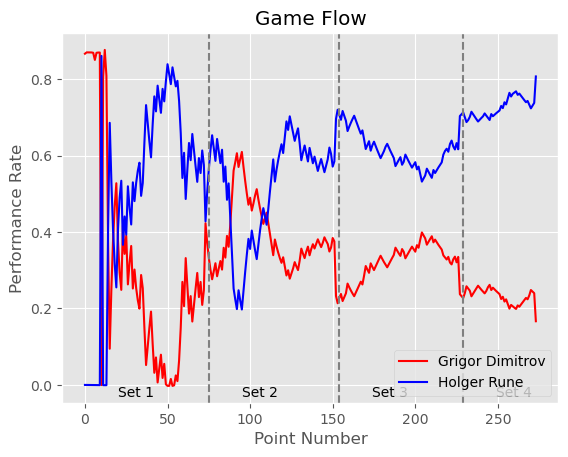

Holger Rune is winning going into set 3 with:  0.7070109131062772 momentum
Holger Rune is winning going into set 4 with:  0.7131586911186141 momentum
set 3 prediction is correct
set 4 prediction is correct


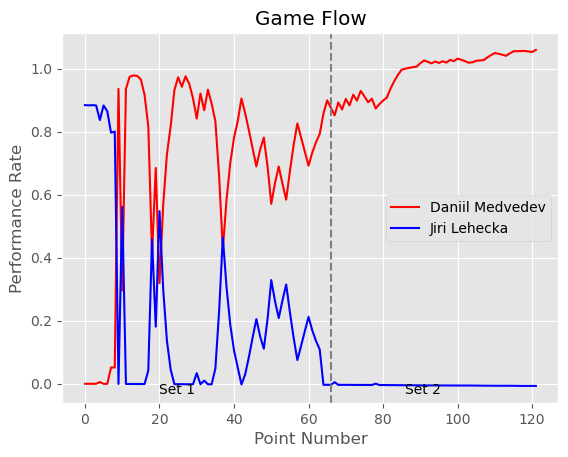

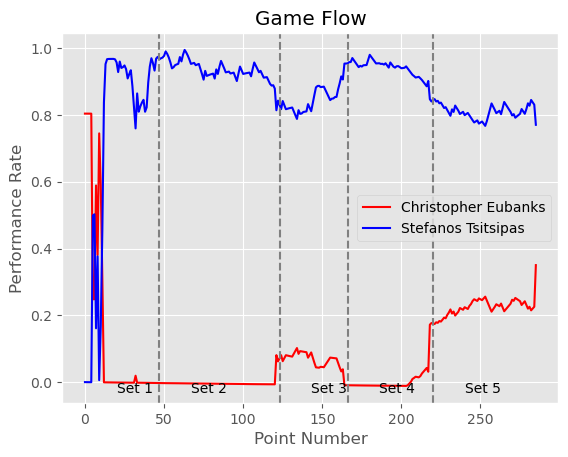

Stefanos Tsitsipas is winning going into set 3 with:  0.8300346498718368 momentum
Stefanos Tsitsipas is winning going into set 4 with:  0.9543962585509443 momentum
Stefanos Tsitsipas is winning going into set 5 with:  0.8456323330006086 momentum
set 3 prediction is wrong
set 4 prediction is wrong
set 5 prediction is wrong


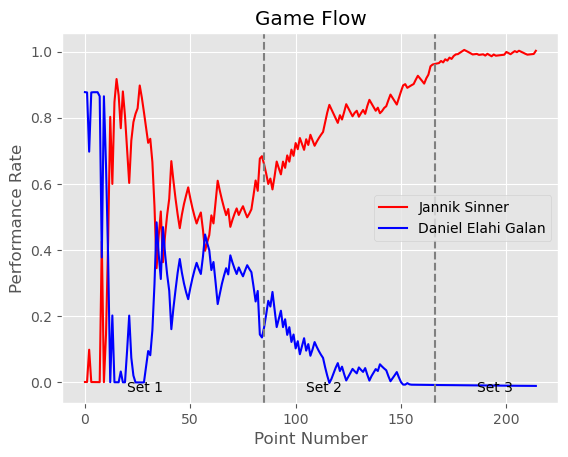

Jannik Sinner is winning going into set 3 with:  0.9626972941960227 momentum
set 3 prediction is correct


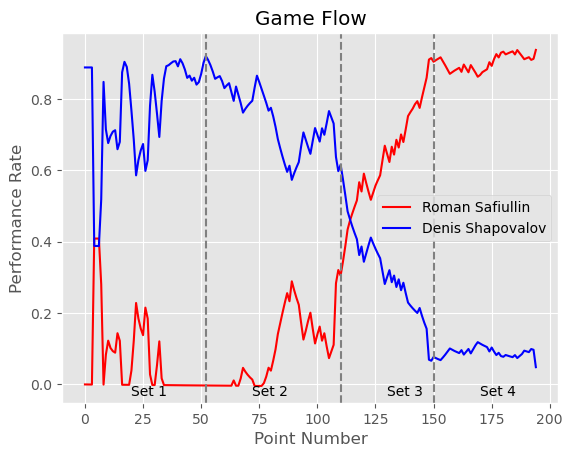

Denis Shapovalov is winning going into set 3 with:  0.6154694815409493 momentum
Roman Safiullin is winning going into set 4 with:  0.9039546234626517 momentum
set 3 prediction is wrong
set 4 prediction is correct


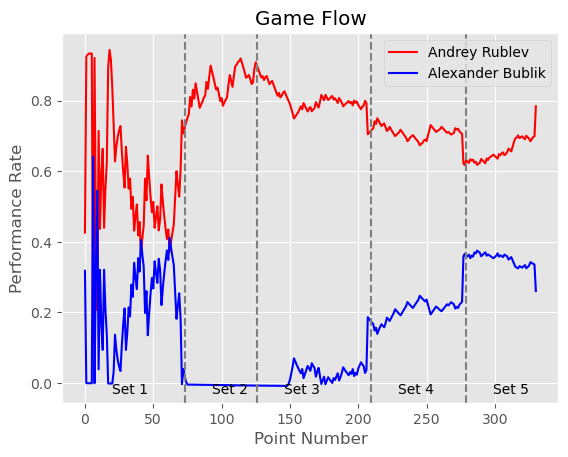

Andrey Rublev is winning going into set 3 with:  0.897789538781408 momentum
Andrey Rublev is winning going into set 4 with:  0.713538941660591 momentum
Andrey Rublev is winning going into set 5 with:  0.6316290326982277 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


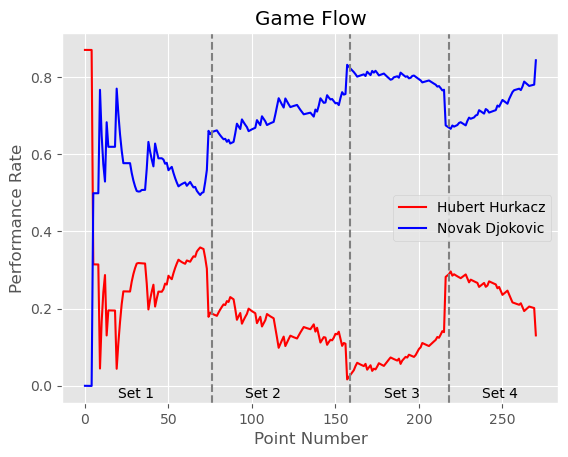

Novak Djokovic is winning going into set 3 with:  0.8221366158196918 momentum
Novak Djokovic is winning going into set 4 with:  0.6688521724135291 momentum
set 3 prediction is correct
set 4 prediction is correct


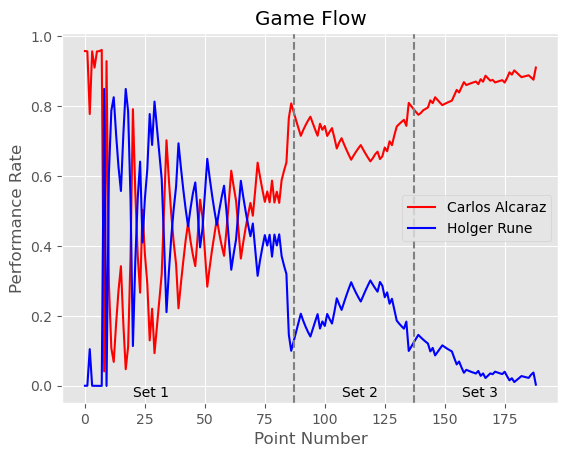

Carlos Alcaraz is winning going into set 3 with:  0.7918268463926268 momentum
set 3 prediction is correct


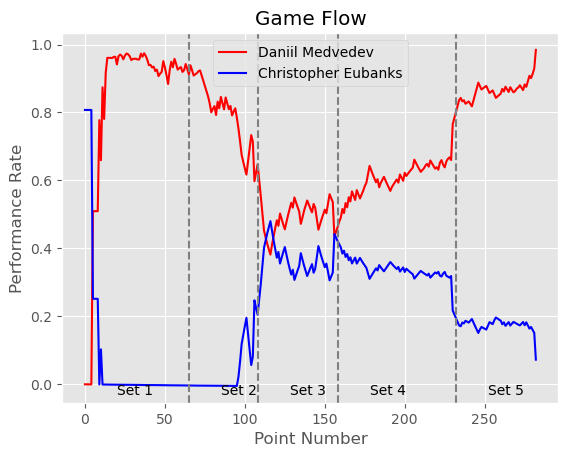

Daniil Medvedev is winning going into set 3 with:  0.6475868032162896 momentum
Daniil Medvedev is winning going into set 4 with:  0.4622383938390176 momentum
Daniil Medvedev is winning going into set 5 with:  0.800793064802655 momentum
set 3 prediction is correct
set 4 prediction is correct
set 5 prediction is correct


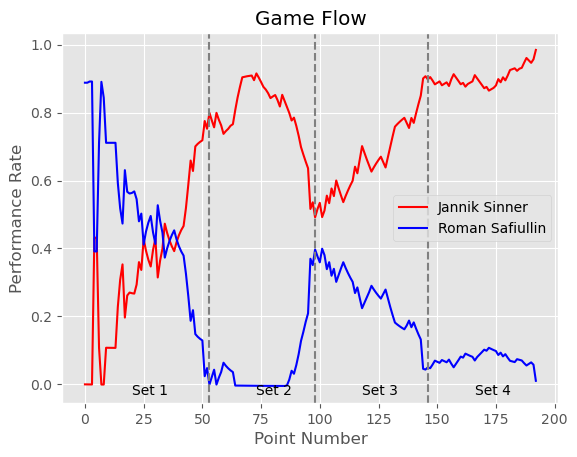

Jannik Sinner is winning going into set 3 with:  0.4916505010034574 momentum
Jannik Sinner is winning going into set 4 with:  0.8978123333005432 momentum
set 3 prediction is correct
set 4 prediction is correct


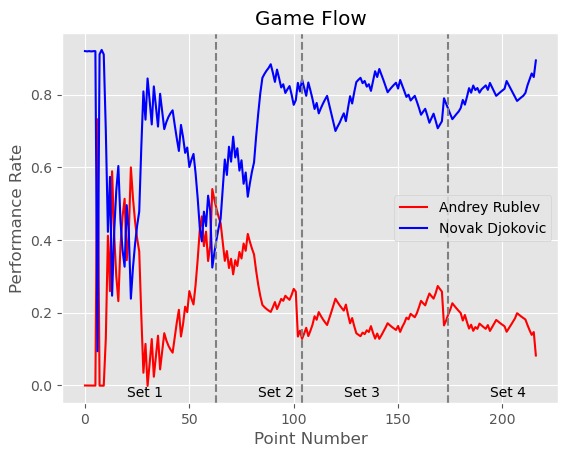

Novak Djokovic is winning going into set 3 with:  0.8417819286214577 momentum
Novak Djokovic is winning going into set 4 with:  0.7605386714948965 momentum
set 3 prediction is correct
set 4 prediction is correct


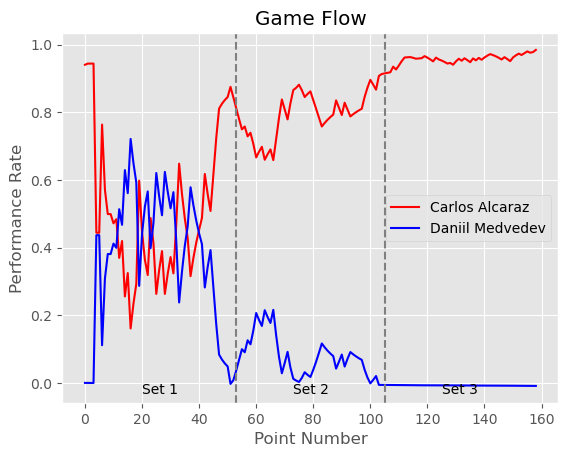

Carlos Alcaraz is winning going into set 3 with:  0.9150616972502494 momentum
set 3 prediction is correct


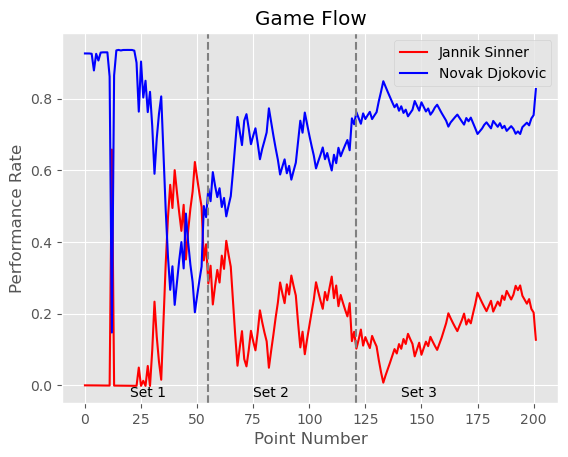

Novak Djokovic is winning going into set 3 with:  0.7626947070752853 momentum
set 3 prediction is correct


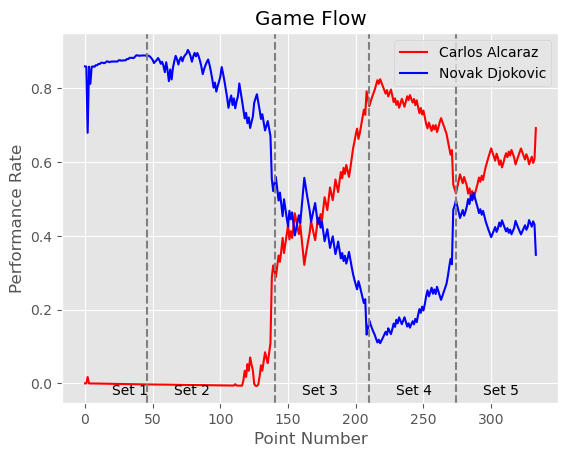

Novak Djokovic is winning going into set 3 with:  0.5430303156329837 momentum
Carlos Alcaraz is winning going into set 4 with:  0.7521211853869666 momentum
Carlos Alcaraz is winning going into set 5 with:  0.5153620145691362 momentum
set 3 prediction is wrong
set 4 prediction is correct
set 5 prediction is correct
Predicted winner at set 2 correctly [24] / 31 times
Predicted winner at set 3 correctly [24] / 30 times
Predicted winner at set 4 correctly [16] / 18 times
Predicted winner at set 5 correctly [4] / 7 times


In [211]:
if True:
    FILE = '2023-wimbledon-data.csv'
    # 2023 Matches
    MATCHES_TO_EXAMINE = ['2023-wimbledon-1301', '2023-wimbledon-1302', '2023-wimbledon-1303', '2023-wimbledon-1304', '2023-wimbledon-1305','2023-wimbledon-1306','2023-wimbledon-1307','2023-wimbledon-1308','2023-wimbledon-1309',
                        '2023-wimbledon-1310','2023-wimbledon-1311','2023-wimbledon-1312','2023-wimbledon-1313','2023-wimbledon-1314','2023-wimbledon-1315','2023-wimbledon-1316','2023-wimbledon-1401','2023-wimbledon-1402',
                        '2023-wimbledon-1403','2023-wimbledon-1404','2023-wimbledon-1405','2023-wimbledon-1406','2023-wimbledon-1407','2023-wimbledon-1408','2023-wimbledon-1501','2023-wimbledon-1502','2023-wimbledon-1503',
                        '2023-wimbledon-1504','2023-wimbledon-1601','2023-wimbledon-1602','2023-wimbledon-1701']
if False:
    FILE = '2021-wimbledon-data.csv'
    # 2021 Matches
    MATCHES_TO_EXAMINE = [
                        '2021-wimbledon-1101', '2021-wimbledon-1102', '2021-wimbledon-1103', '2021-wimbledon-1104', '2021-wimbledon-1105',
                        '2021-wimbledon-1106', '2021-wimbledon-1107', '2021-wimbledon-1108', '2021-wimbledon-1109', '2021-wimbledon-1110',
                        '2021-wimbledon-1111', '2021-wimbledon-1112', '2021-wimbledon-1113', '2021-wimbledon-1114', '2021-wimbledon-1115',
                        '2021-wimbledon-1116', '2021-wimbledon-1117', '2021-wimbledon-1118', '2021-wimbledon-1119', '2021-wimbledon-1120',
                        '2021-wimbledon-1121', '2021-wimbledon-1122', '2021-wimbledon-1123', '2021-wimbledon-1124', '2021-wimbledon-1125',
                        '2021-wimbledon-1126', '2021-wimbledon-1127', '2021-wimbledon-1128', '2021-wimbledon-1129', '2021-wimbledon-1130',
                        '2021-wimbledon-1131', '2021-wimbledon-1132', '2021-wimbledon-1133', '2021-wimbledon-1134', '2021-wimbledon-1135',
                        '2021-wimbledon-1136', '2021-wimbledon-1137', '2021-wimbledon-1138', '2021-wimbledon-1139', '2021-wimbledon-1140',
                        '2021-wimbledon-1141', '2021-wimbledon-1142', '2021-wimbledon-1143', '2021-wimbledon-1144', '2021-wimbledon-1145',
                        '2021-wimbledon-1146', '2021-wimbledon-1147', '2021-wimbledon-1148', '2021-wimbledon-1150', '2021-wimbledon-1151', 
                        '2021-wimbledon-1152', '2021-wimbledon-1153', '2021-wimbledon-1154', '2021-wimbledon-1155', '2021-wimbledon-1156', 
                        '2021-wimbledon-1157', '2021-wimbledon-1158', '2021-wimbledon-1159', '2021-wimbledon-1160', '2021-wimbledon-1161', 
                        '2021-wimbledon-1162', '2021-wimbledon-1163', '2021-wimbledon-1164', '2021-wimbledon-1201', '2021-wimbledon-1202', 
                        '2021-wimbledon-1203', '2021-wimbledon-1204', '2021-wimbledon-1205', '2021-wimbledon-1206', '2021-wimbledon-1207', 
                        '2021-wimbledon-1208', '2021-wimbledon-1209', '2021-wimbledon-1210', '2021-wimbledon-1211', '2021-wimbledon-1212', 
                        '2021-wimbledon-1214', '2021-wimbledon-1215', '2021-wimbledon-1216', '2021-wimbledon-1217', '2021-wimbledon-1218', 
                        '2021-wimbledon-1219', '2021-wimbledon-1220', '2021-wimbledon-1221', '2021-wimbledon-1222', '2021-wimbledon-1223', 
                        '2021-wimbledon-1224', '2021-wimbledon-1225', '2021-wimbledon-1226', '2021-wimbledon-1227', '2021-wimbledon-1228', 
                        '2021-wimbledon-1229', '2021-wimbledon-1230', '2021-wimbledon-1231', '2021-wimbledon-1232', '2021-wimbledon-1301', 
                        '2021-wimbledon-1302', '2021-wimbledon-1303', '2021-wimbledon-1304', '2021-wimbledon-1305', '2021-wimbledon-1306', 
                        '2021-wimbledon-1307', '2021-wimbledon-1308', '2021-wimbledon-1309', '2021-wimbledon-1310', '2021-wimbledon-1311', 
                        '2021-wimbledon-1312', '2021-wimbledon-1313', '2021-wimbledon-1314', '2021-wimbledon-1315', '2021-wimbledon-1316', 
                        '2021-wimbledon-1401', '2021-wimbledon-1402', '2021-wimbledon-1403', '2021-wimbledon-1404', '2021-wimbledon-1405', 
                        '2021-wimbledon-1406', '2021-wimbledon-1407', '2021-wimbledon-1408', '2021-wimbledon-1501', '2021-wimbledon-1502', 
                        '2021-wimbledon-1503', '2021-wimbledon-1504', '2021-wimbledon-1601', '2021-wimbledon-1602', '2021-wimbledon-1701']

if False:
    FILE = '2021-wimbledon-data.csv'
    # 2021 matches of 5 sets
    MATCHES_TO_EXAMINE = [
                        '2021-wimbledon-1104', '2021-wimbledon-1105', '2021-wimbledon-1107', '2021-wimbledon-1108', 
                        '2021-wimbledon-1122', '2021-wimbledon-1123', '2021-wimbledon-1125', '2021-wimbledon-1126', 
                        '2021-wimbledon-1127', '2021-wimbledon-1136', '2021-wimbledon-1140', '2021-wimbledon-1142', 
                        '2021-wimbledon-1144', '2021-wimbledon-1158', '2021-wimbledon-1163', '2021-wimbledon-1214',
                        '2021-wimbledon-1215', '2021-wimbledon-1216', '2021-wimbledon-1223', '2021-wimbledon-1316', 
                        '2021-wimbledon-1402', '2021-wimbledon-1403', '2021-wimbledon-1406', '2021-wimbledon-1408', 
                        '2021-wimbledon-1502']

set1_correct = set1_total = set2_correct = set2_total = set3_correct = set3_total = set4_correct = set4_total = 0

for MATCH_TO_EXAMINE in MATCHES_TO_EXAMINE:
    model = MarkovChain(FILE, MATCH_TO_EXAMINE)
    model.train()
    model.graph_momentum()
    result_array = model.prediction()

    try:
        set1_correct += result_array[0]
        set1_total += 1

        set2_correct += result_array[1]
        set2_total += 1

        set3_correct += result_array[2]
        set3_total += 1

        set4_correct += result_array[3]
        set4_total += 1
    finally:
        continue

print(f"Predicted winner at set 2 correctly {set1_correct} / {set1_total} times")
print(f"Predicted winner at set 3 correctly {set2_correct} / {set2_total} times")
print(f"Predicted winner at set 4 correctly {set3_correct} / {set3_total} times")
print(f"Predicted winner at set 5 correctly {set4_correct} / {set4_total} times")